# Profiling and Analysis Questions

- Do users purchase different products at different time of day?
- What clusters of aisle purchase standout?
- Do users who reorder have different behaviour? 
- does the behaviour change per number of order (eg.: min vs median, etc)
- do users purchase differently depending on days or weeks since last purchase?
- do users purchase differently on the weekends vs weekday?
- What is the top product/aisle purchased first or last per order?
- Reordered is per product. what products are most reordered by users?
- how many orders per user_id? 

## Aggregations
- days/weeks since last order
- number of orders (better to consider order number instead of count of order_id due to incomplete customer history)
- number of users who reordered
- orders per time of day (numeric or discrete count)


# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [2]:
%run "scripts/dslabs_functions.py"

# data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:
# test_data=True
test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 5% sample
    data=data.sample(frac=0.05, replace=False)

    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.25, replace=False)


else:
    data=pd.read_csv(filepath)
    
    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.01, replace=False)



data=enrich_instacart_df(data)


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']
# data=data.drop(columns=id_cols, axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 25 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   order_id                 int64  
 1   product_id               int64  
 2   add_to_cart_order        int64  
 3   reordered                int64  
 4   user_id                  int64  
 5   order_number             int64  
 6   order_dow                int64  
 7   order_hour_of_day        int64  
 8   days_since_prior_order   float64
 9   order_time_of_day        object 
 10  is_weekend               int64  
 11  is_peak_time_of_day      int64  
 12  weeks_since_prior_order  float64
 13  order_time_of_day_enc    float64
 14  order_hour_of_day_sin    float64
 15  order_hour_of_day_cos    float64
 16  order_dow_sin            float64
 17  order_dow_cos            float64
 18  num_products             int64  
 19  reorder_rate             float64
 20  product_name             object 
 21  aisle_

# Dimensionality

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


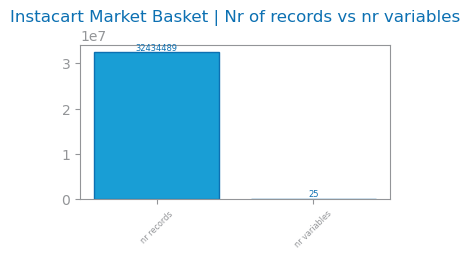

In [5]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title=f"{file_tag} | Nr of records vs nr variables"
)
# savefig(f"{file_tag}_records_variables.png")
show()

## Missing values
- Only missing values for dataset are the columns "days since last order" at 6.5%. When the order is the user's first, this column shows empty values. It cannot be filled with '0' since there are users that can make multiple orders in the same day. Would not remove it as well as it can be used for analysis questions like 'behaviour on first order'?

In [6]:
data.isnull().sum()


order_id                         0
product_id                       0
add_to_cart_order                0
reordered                        0
user_id                          0
order_number                     0
order_dow                        0
order_hour_of_day                0
days_since_prior_order     2078068
order_time_of_day                0
is_weekend                       0
is_peak_time_of_day              0
weeks_since_prior_order    2078068
order_time_of_day_enc            0
order_hour_of_day_sin            0
order_hour_of_day_cos            0
order_dow_sin                    0
order_dow_cos                    0
num_products                     0
reorder_rate                     0
product_name                     0
aisle_id                         0
department_id                    0
aisle                            0
department                       0
dtype: int64

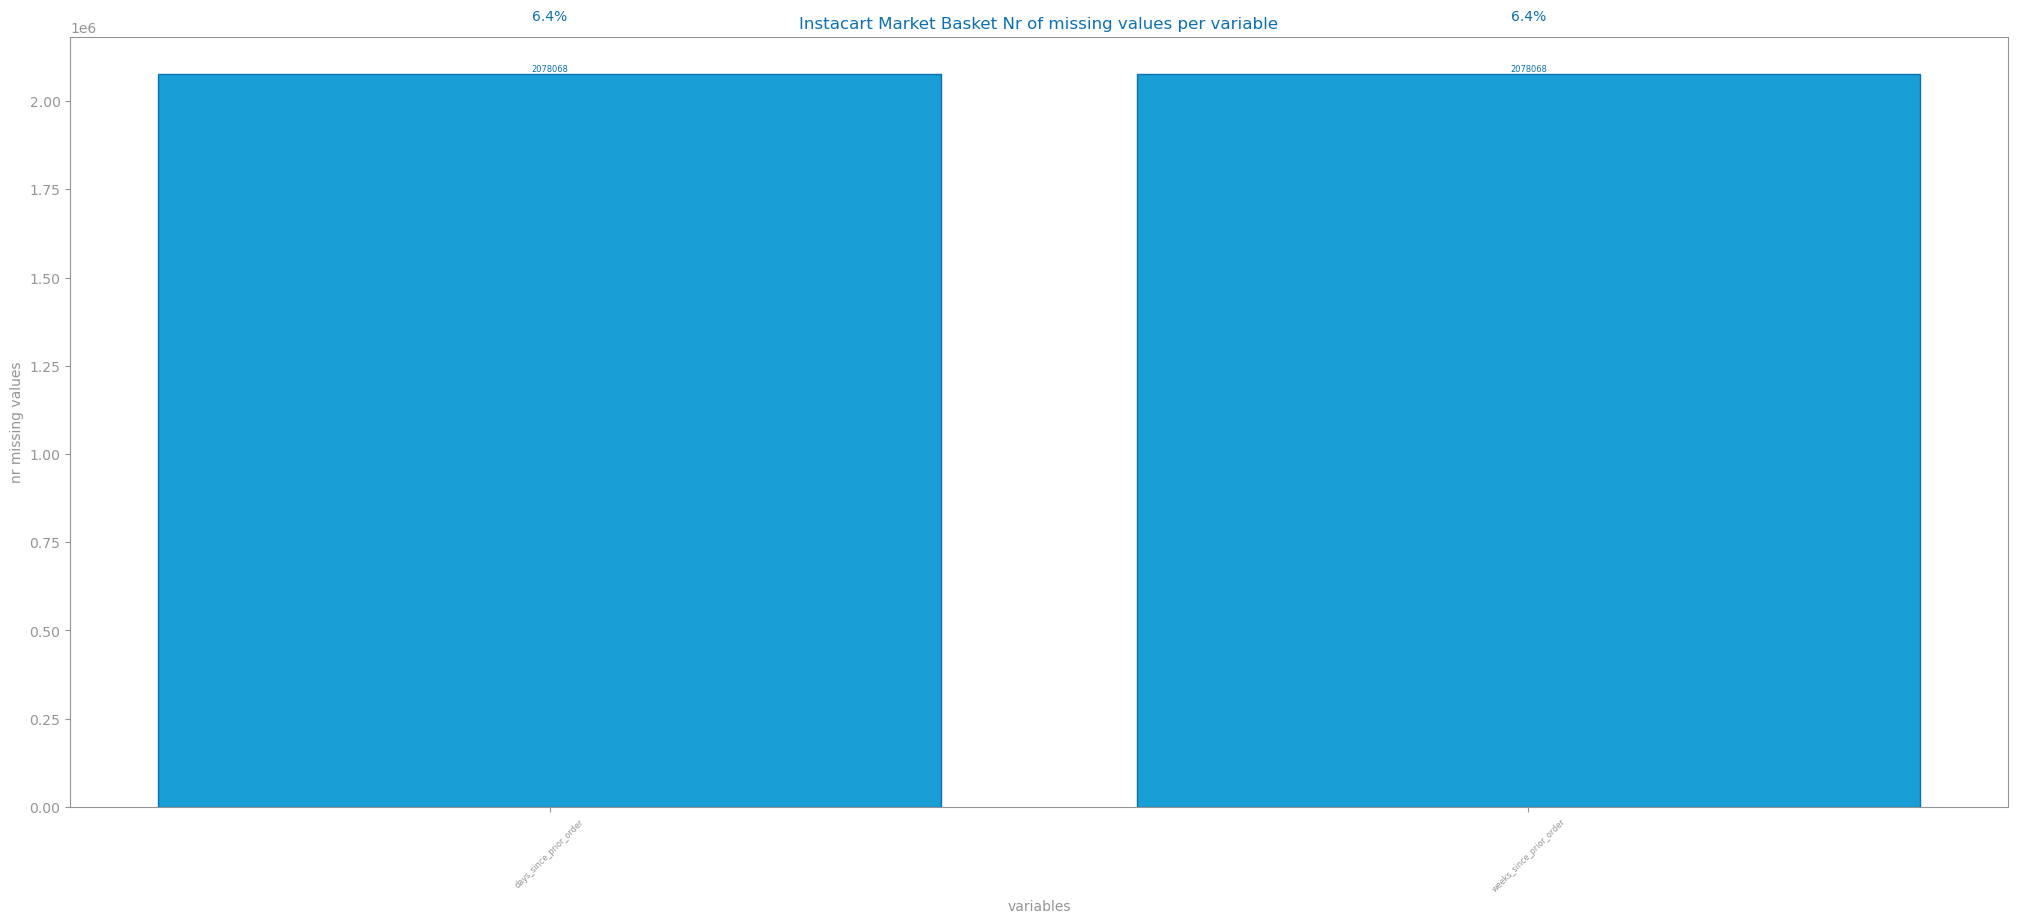

In [7]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
total_rows = len(data)

for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

figure(figsize=(25, 10)) #(largura,altura) 

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

savefig(f"images/{file_tag}_mv.png")
show()

## Variables Type

In [8]:
data.dtypes


order_id                     int64
product_id                   int64
add_to_cart_order            int64
reordered                    int64
user_id                      int64
order_number                 int64
order_dow                    int64
order_hour_of_day            int64
days_since_prior_order     float64
order_time_of_day           object
is_weekend                   int64
is_peak_time_of_day          int64
weeks_since_prior_order    float64
order_time_of_day_enc      float64
order_hour_of_day_sin      float64
order_hour_of_day_cos      float64
order_dow_sin              float64
order_dow_cos              float64
num_products                 int64
reorder_rate               float64
product_name                object
aisle_id                     int64
department_id                int64
aisle                       object
department                  object
dtype: object

In [9]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order', 'order_time_of_day_enc', 'order_hour_of_day_sin', 'order_hour_of_day_cos', 'order_dow_sin', 'order_dow_cos', 'num_products', 'reorder_rate'], 'binary': ['reordered', 'is_weekend', 'is_peak_time_of_day'], 'date': [], 'symbolic': ['order_time_of_day', 'product_name', 'aisle', 'department'], 'id': ['order_id', 'product_id', 'user_id', 'aisle_id', 'department_id']}


### variables per type plot

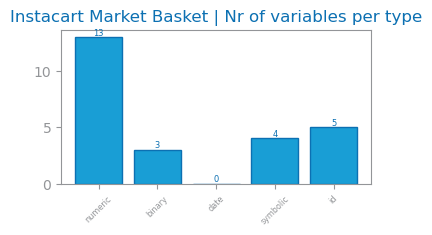

In [10]:
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title=f"{file_tag} | Nr of variables per type"
)
# savefig(f"{file_tag}_variable_types.png")
show()

# Data Distribution

## describe

In [11]:
summary5: DataFrame = data.describe(include="all")
summary5

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_time_of_day,...,order_hour_of_day_cos,order_dow_sin,order_dow_cos,num_products,reorder_rate,product_name,aisle_id,department_id,aisle,department
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.035642e+07,32434489,...,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,32434489,3.243449e+07,3.243449e+07,32434489,32434489
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,...,NaN,NaN,NaN,NaN,NaN,49677,NaN,NaN,134,21
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afternoon,...,NaN,NaN,NaN,NaN,NaN,Banana,NaN,NaN,fresh fruits,produce
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13177678,...,NaN,NaN,NaN,NaN,NaN,472565,NaN,NaN,3642188,9479291
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01,1.029372e+05,1.714205e+01,2.738818e+00,1.342498e+01,1.110407e+01,NaN,...,-4.433478e-01,5.038182e-02,2.405168e-01,1.570215e+01,5.896975e-01,NaN,7.121430e+01,9.921906e+00,NaN,NaN
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01,5.946648e+04,1.753504e+01,2.090049e+00,4.246365e+00,8.778914e+00,NaN,...,5.871222e-01,6.410302e-01,7.271132e-01,9.538288e+00,3.115006e-01,NaN,3.820302e+01,6.281156e+00,NaN,NaN
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,...,-9.906859e-01,-8.660254e-01,-1.000000e+00,1.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,NaN,NaN
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00,5.142100e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,NaN,...,-9.172113e-01,-2.449294e-16,-5.000000e-01,9.000000e+00,3.636364e-01,NaN,3.100000e+01,4.000000e+00,NaN,NaN
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00,1.026110e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,NaN,...,-5.766803e-01,0.000000e+00,5.000000e-01,1.400000e+01,6.400000e-01,NaN,8.300000e+01,9.000000e+00,NaN,NaN
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00,1.543910e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,NaN,...,-6.824241e-02,8.660254e-01,1.000000e+00,2.100000e+01,8.571429e-01,NaN,1.070000e+02,1.600000e+01,NaN,NaN


## Numeric Variables

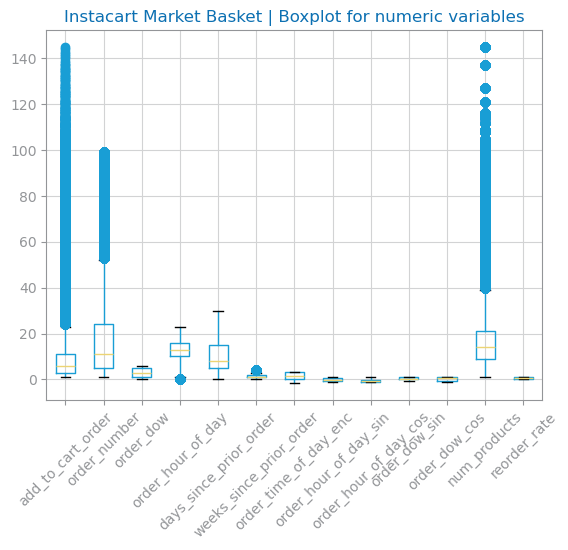

In [12]:
from matplotlib.pyplot import savefig, show, title


variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    data[numeric].boxplot(rot=45)
    title(f'{file_tag} | Boxplot for numeric variables')  # Correct way to set title
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

## numeric variables distribution breakdown
- add_to_cart_order, order number and weeks since last order should be truncated or removed

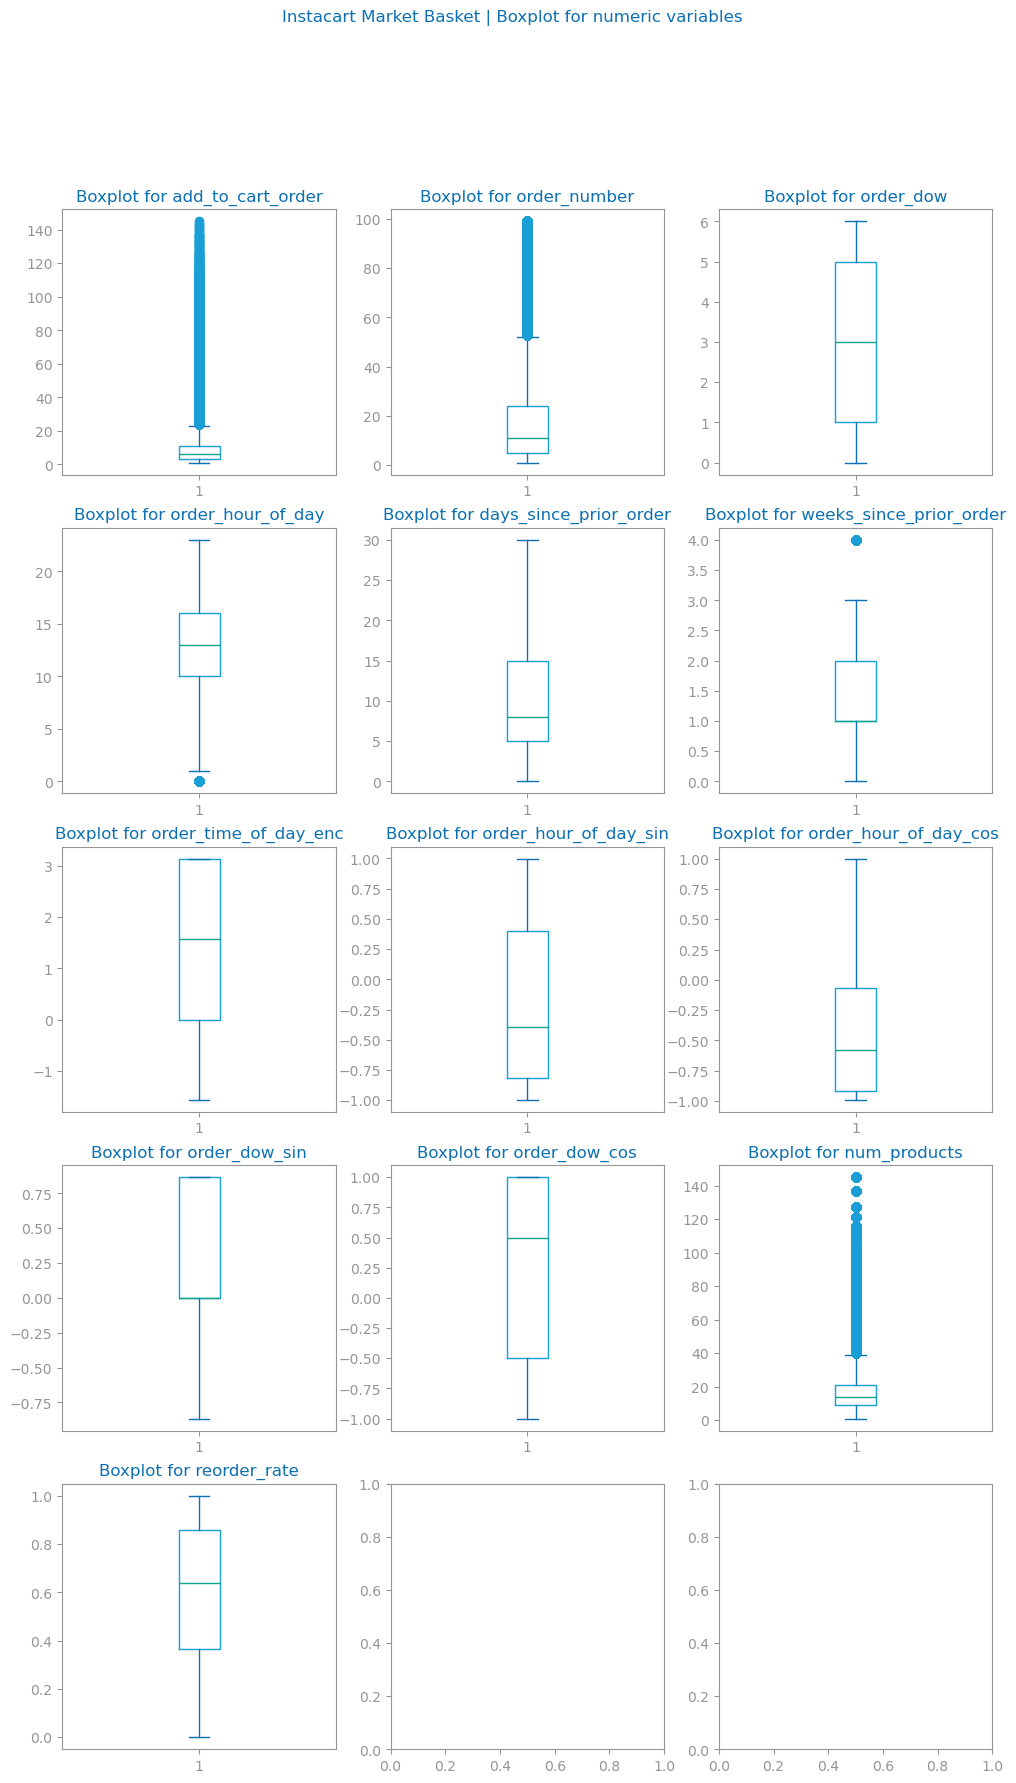

In [13]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## standard outliers for numeric variables

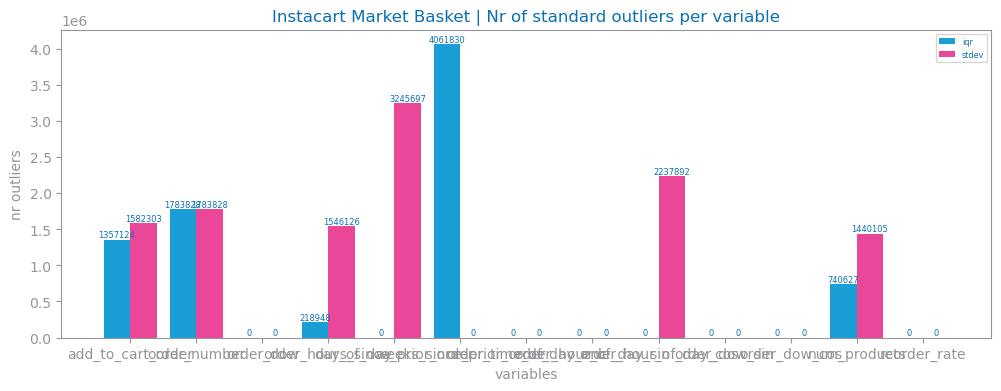

In [14]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

## outliers factorized

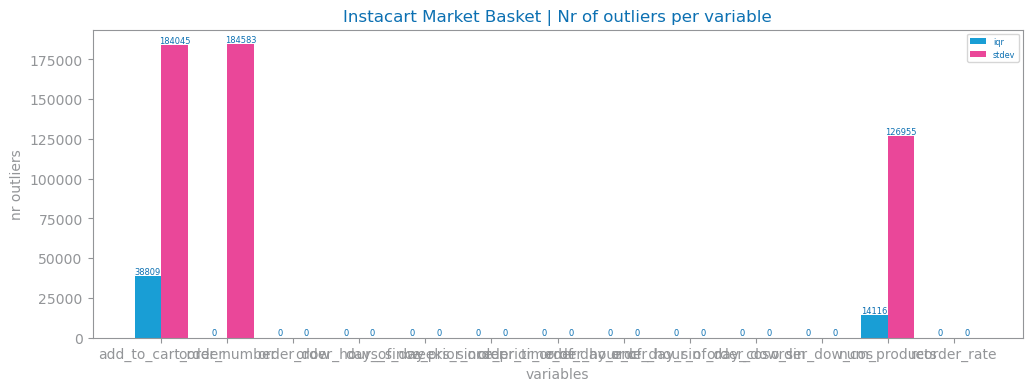

In [15]:
if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=4, iqrfactor=4.5)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers.png")
    show()
else:
    print("There are no numeric variables.")

## numeric histograms

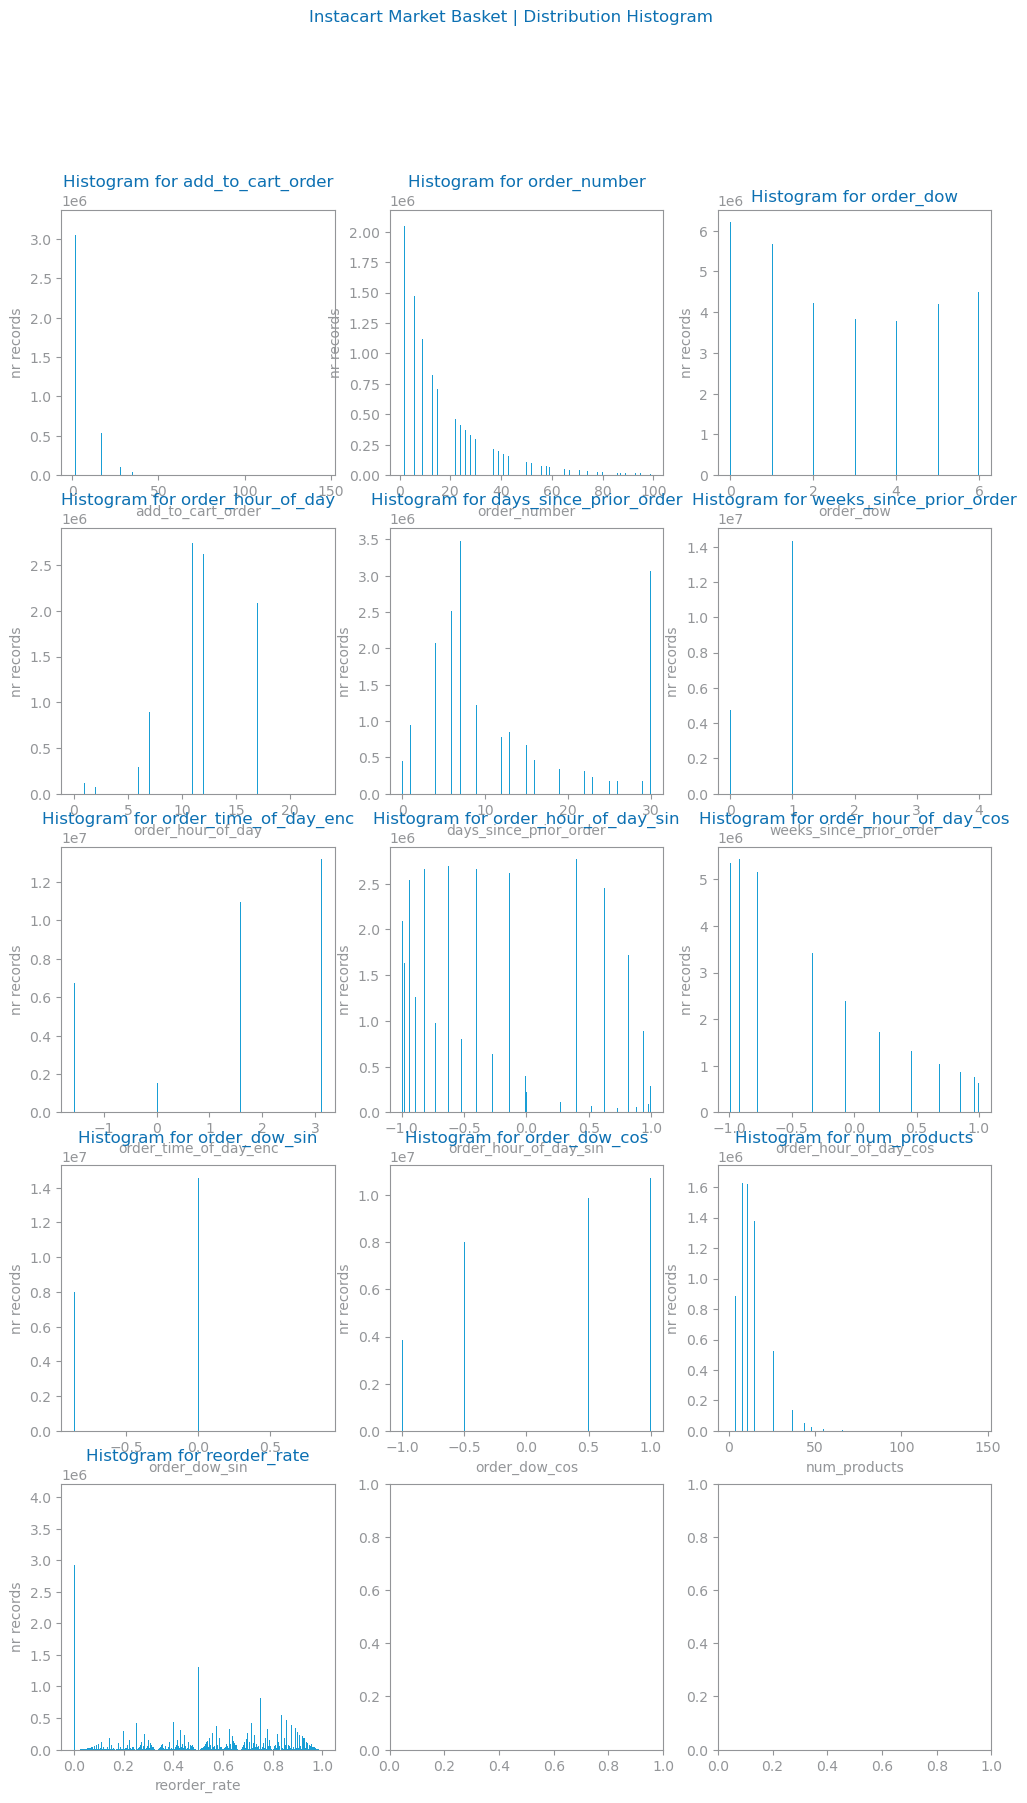

In [16]:
from dslabs_functions import set_chart_labels


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    
    fig.suptitle(f'{file_tag} | Distribution Histogram')

    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

# Symbolic Variables

## count by order id, user_id

In [17]:
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import display

# List of columns to group by
groupby_cols = ['order_time_of_day', 'product_name', 'aisle', 'department', 'reordered', 'is_weekend', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order']

# count unique values of the id columns
count_cols=['order_id', 'user_id']

# Dictionary to store the resulting dataframes
grouped_dataframes = {}

# Loop through the list of columns and perform groupby and aggregation
for col in groupby_cols:
    grouped_df = data.groupby(col)[count_cols].nunique().sort_values(by=count_cols[0], ascending=False)
    
    # Calculate the percentage share for each count column
    for count_col in count_cols:
        grouped_df[f'{count_col}_share'] = (grouped_df[count_col] / grouped_df[count_col].sum() * 100).round(2)
    
    grouped_dataframes[col] = grouped_df

# Display the resulting dataframes as HTML tables
for col, df in grouped_dataframes.items():
    display(HTML(f"<h3>Group by {col}</h3>"))
    display(df.head(20))

,order_id,user_id,order_id_share,user_id_share
order_time_of_day,,,,
Afternoon,1305017,192657,40.59,32.91
Morning,1076128,173846,33.47,29.70
Evening,688243,156701,21.41,26.77
Night,145486,62155,4.53,10.62


,order_id,user_id,order_id_share,user_id_share
product_name,,,,
Banana,472565,73956,1.46,0.56
Bag of Organic Bananas,379450,63537,1.17,0.48
Organic Strawberries,264683,58838,0.82,0.44
Organic Baby Spinach,241921,55037,0.75,0.41
Organic Hass Avocado,213584,43453,0.66,0.33
Organic Avocado,176815,42771,0.55,0.32
Large Lemon,152657,46402,0.47,0.35
Strawberries,142951,43149,0.44,0.32
Limes,140627,44859,0.43,0.34


,order_id,user_id,order_id_share,user_id_share
aisle,,,,
fresh fruits,1790771,177141,7.67,3.09
fresh vegetables,1427631,159213,6.12,2.78
packaged vegetables fruits,1179243,159418,5.05,2.78
yogurt,847081,124393,3.63,2.17
milk,785987,109226,3.37,1.91
packaged cheese,737899,132973,3.16,2.32
water seltzer sparkling water,614081,99755,2.63,1.74
soy lactosefree,545714,96326,2.34,1.68
chips pretzels,538052,111930,2.31,1.95


,order_id,user_id,order_id_share,user_id_share
department,,,,
produce,2409320,193237,15.82,8.65
dairy eggs,2177338,190565,14.30,8.53
beverages,1457351,172795,9.57,7.74
snacks,1391447,174219,9.14,7.80
frozen,1181018,163233,7.76,7.31
pantry,1117892,172755,7.34,7.74
bakery,881556,140612,5.79,6.30
deli,770300,133865,5.06,6.00
canned goods,681305,133733,4.47,5.99


,order_id,user_id,order_id_share,user_id_share
reordered,,,,
1,2826361,203164,52.87,49.63
0,2519868,206209,47.13,50.37


,order_id,user_id,order_id_share,user_id_share
is_weekend,,,,
0,2370044,204702,73.72,54.46
1,844830,171154,26.28,45.54


,order_id,user_id,order_id_share,user_id_share
order_number,,,,
1,206209,206209,6.41,6.41
2,206209,206209,6.41,6.41
3,206209,206209,6.41,6.41
4,182223,182223,5.67,5.67
5,162633,162633,5.06,5.06
6,146468,146468,4.56,4.56
7,132618,132618,4.13,4.13
8,120918,120918,3.76,3.76
9,110728,110728,3.44,3.44


,order_id,user_id,order_id_share,user_id_share
order_dow,,,,
0,557772,145300,17.35,15.03
1,556705,151528,17.32,15.67
2,441955,140248,13.75,14.51
5,425982,133893,13.25,13.85
6,418848,128327,13.03,13.27
3,412400,135375,12.83,14.00
4,401212,132186,12.48,13.67


,order_id,user_id,order_id_share,user_id_share
order_hour_of_day,,,,
10,271885,108547,8.46,7.32
11,268006,112873,8.34,7.61
15,266132,115100,8.28,7.76
14,265556,114950,8.26,7.75
13,261174,114318,8.12,7.71
12,256206,113143,7.97,7.63
16,255949,111744,7.96,7.53
9,243496,96512,7.57,6.51
17,214080,99630,6.66,6.72


,order_id,user_id,order_id_share,user_id_share
days_since_prior_order,,,,
7.0,306181,95959,10.18,6.46
30.0,306137,141127,10.18,9.50
6.0,230245,86556,7.65,5.83
4.0,214488,68539,7.13,4.61
3.0,210665,61661,7.00,4.15
5.0,206691,75805,6.87,5.10
2.0,187723,53842,6.24,3.62
8.0,173259,82771,5.76,5.57
1.0,141011,44196,4.69,2.97


,order_id,user_id,order_id_share,user_id_share
weeks_since_prior_order,,,,
1.0,1333246,159121,44.31,23.79
0.0,603835,95704,20.07,14.31
2.0,460166,146258,15.29,21.86
4.0,401067,155826,13.33,23.29
3.0,210351,112065,6.99,16.75


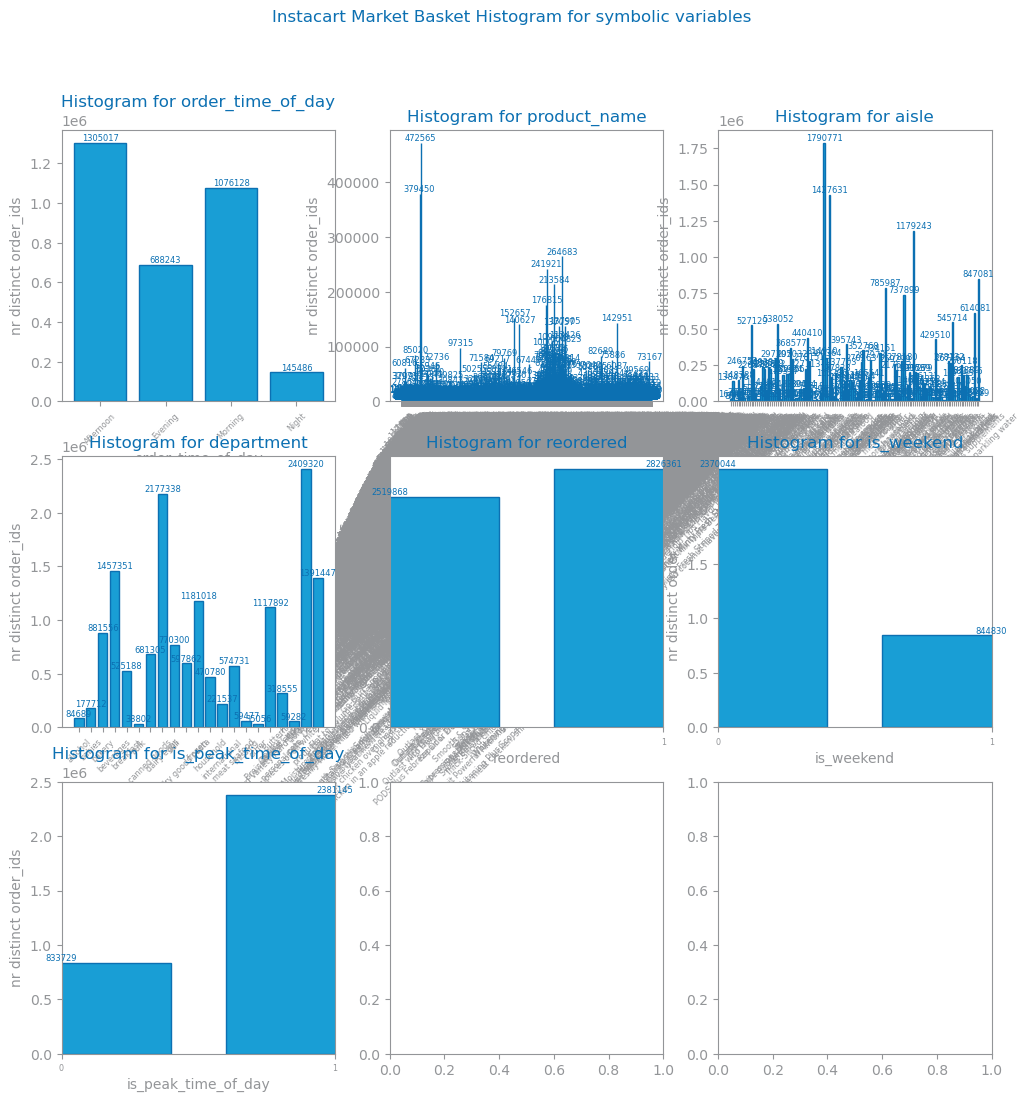

In [18]:
from dslabs_functions import plot_bar_chart

symbolic: list[str] = variable_types["symbolic"] + variable_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0

    fig.suptitle(f'{file_tag} Histogram for symbolic variables')
    
    for n in range(len(symbolic)):
        counts: Series = data.groupby(symbolic[n])['order_id'].nunique()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title=f"Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr distinct order_ids",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")

## Reorder analysis

### reorder per aisle

In [19]:
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import display

# which aisles are most reordered in %
aisle_reorder = data.groupby('aisle')['order_id'].nunique().reset_index(name='total')
aisle_reorder = aisle_reorder.merge(
    data[data['reordered'] == 1].groupby('aisle')['order_id'].nunique().reset_index(name='reordered'),
    on='aisle',
    how='left'
).fillna(0)
aisle_reorder['reordered_share'] = (aisle_reorder['reordered'] / aisle_reorder['total']) * 100
aisle_reorder = aisle_reorder.sort_values(by='total', ascending=False).reset_index()

display(HTML("<h3>Aisles most reordered in %</h3>"))
display(aisle_reorder)

,index,aisle,total,reordered,reordered_share
0,50,fresh fruits,1790771,1427069,79.690200
1,53,fresh vegetables,1427631,1021337,71.540685
2,98,packaged vegetables fruits,1179243,819862,69.524432
3,133,yogurt,847081,627029,74.022319
4,83,milk,785987,622449,79.193295
...,...,...,...,...,...
129,44,eye ear care,8619,1909,22.148741
130,2,baby accessories,8078,4484,55.508789
131,3,baby bath body care,7956,2476,31.121166
132,8,beauty,5837,1289,22.083262


In [20]:
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import display

# which aisles are most reordered in %
department_reorder = data.groupby('department')['order_id'].nunique().reset_index(name='total')
department_reorder = department_reorder.merge(
    data[data['reordered'] == 1].groupby('department')['order_id'].nunique().reset_index(name='reordered'),
    on='department',
    how='left'
).fillna(0)
department_reorder['reordered_share'] = (department_reorder['reordered'] / department_reorder['total']) * 100
department_reorder = department_reorder.sort_values(by='total', ascending=False).reset_index()

display(HTML("<h3>departments most reordered in %</h3>"))
display(department_reorder)

,index,department,total,reordered,reordered_share
0,19,produce,2409320,1962871,81.469917
1,7,dairy eggs,2177338,1695208,77.856906
2,3,beverages,1457351,1068642,73.327702
3,20,snacks,1391447,929981,66.835532
4,10,frozen,1181018,761976,64.518576
5,16,pantry,1117892,499539,44.685801
6,2,bakery,881556,589018,66.815721
7,8,deli,770300,502229,65.199143
8,6,canned goods,681305,365838,53.696656
9,9,dry goods pasta,597862,312040,52.192646


# Correlation Analysis

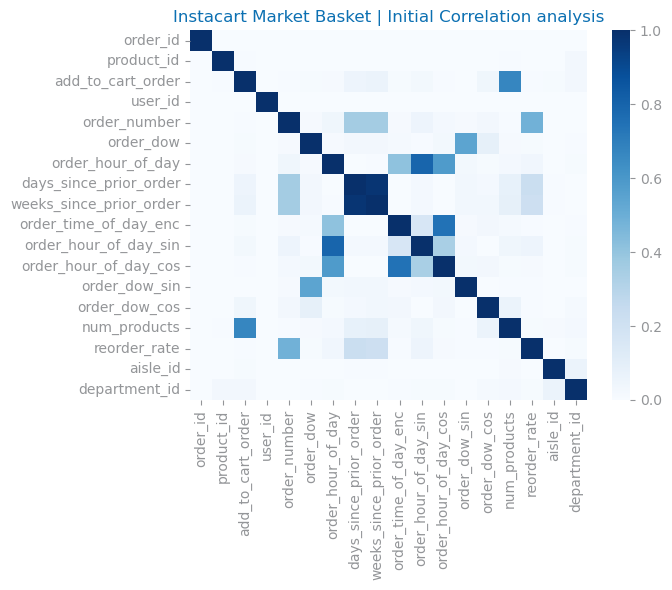

In [21]:
from seaborn import heatmap
from dslabs_functions import get_variable_types
from matplotlib.pyplot import figure, title, savefig, show

variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = data[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)

title(f'{file_tag} | Initial Correlation analysis')

savefig(f"images/{file_tag}_correlation_analysis.png")
show()